In [1]:
import os
import glob
import numpy as np 
import xarray as xr
import pandas as pd
import datetime
from datetime import date, timedelta
import dask
import re
import scipy.stats as stats
import scipy.signal as signal
from skimage.measure import find_contours

# Plotting utils 
# import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cartopy
import cartopy.crs as ccrs
import seaborn as sns



In [2]:
# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds

# - - - - - - - - - - - - - - - 
# Pre-process data while reading in 
# - - - - - - - - - - - - - - - 

def preprocess_h0(ds):
       
    keepVars = ['SWCF','LWCF','TS','CLOUD','FSNS','FLNS','PS',
                    'U10','CLDHGH','CLDLIQ','TMQ',
                    'CDNUMC','CLDLOW',
                    'CLDMED','CLDTOT','RVMTEND_CLUBB','STEND_CLUBB',
                    'T','Q','OMEGA','PBLH','U','V','Z3',
                    'PRECT','PRECC','PRECL','LANDFRAC','OCNFRAC', 'ICEFRAC',
                    'TGCLDLWP','LHFLX','SHFLX','TREFHT', 'TAUX','TAUY',
                    'hyam','hybm','hyai','hybi']
        
    # ds         = cesm_correct_time(ds)
    # ds['time'] = ds.indexes['time'].to_datetimeindex() 
    dsSel      = ds[keepVars]
    
    return dsSel


def regrid_data(fromthis, tothis, method=1):
    """Regrid data using various different methods"""

    #Import necessary modules:
    import xarray as xr

    if method == 1:
        # kludgy: spatial regridding only, seems like can't automatically deal with time
        if 'time' in fromthis.coords:
            result = [fromthis.isel(time=t).interp_like(tothis) for t,time in enumerate(fromthis['time'])]
            result = xr.concat(result, 'time')
            return result
        else:
            return fromthis.interp_like(tothis)
    elif method == 2:
        newlat = tothis['lat']
        newlon = tothis['lon']
        coords = dict(fromthis.coords)
        coords['lat'] = newlat
        coords['lon'] = newlon
        return fromthis.interp(coords)
    elif method == 3:
        newlat = tothis['lat']
        newlon = tothis['lon']
        ds_out = xr.Dataset({'lat': newlat, 'lon': newlon})
        regridder = xe.Regridder(fromthis, ds_out, 'bilinear')
        return regridder(fromthis)
    elif method==4:
        # geocat
        newlat = tothis['lat']
        newlon = tothis['lon']
        result = geocat.comp.linint2(fromthis, newlon, newlat, False)
        result.name = fromthis.name
        
        return result

def wgt_rmse(fld1, fld2, wgt):
    """Calculate the area-weighted RMSE.

    Parameters
    ----------
    fld1, fld2 : array-like
        2-dimensional spatial fields with the same shape.
        They can be xarray DataArray or numpy arrays.
    wgt : array-like
        the weight vector, expected to be 1-dimensional,
        matching length of one dimension of the data.

    Returns
    -------
    float
        root mean squared error

    Notes:
    ```rmse = sqrt( mean( (fld1 - fld2)**2 ) )```
    """
    assert len(fld1.shape) == 2,     "Input fields must have exactly two dimensions."
    assert fld1.shape == fld2.shape, "Input fields must have the same array shape."
    # in case these fields are in dask arrays, compute them now.
    if hasattr(fld1, "compute"):
        fld1 = fld1.compute()
    if hasattr(fld2, "compute"):
        fld2 = fld2.compute()
    if isinstance(fld1, xr.DataArray) and isinstance(fld2, xr.DataArray):
        return (np.sqrt(((fld1 - fld2)**2).weighted(wgt).mean())).values.item()
    else:
        check = [len(wgt) == s for s in fld1.shape]
        if ~np.any(check):
            raise IOError(f"Sorry, weight array has shape {wgt.shape} which is not compatible with data of shape {fld1.shape}")
        check = [len(wgt) != s for s in fld1.shape]
        dimsize = fld1.shape[np.argwhere(check).item()]  # want to get the dimension length for the dim that does not match the size of wgt
        warray = np.tile(wgt, (dimsize, 1)).transpose()   # May need more logic to ensure shape is correct.
        warray = warray / np.sum(warray) # normalize
        wmse = np.sum(warray * (fld1 - fld2)**2)
    
        return np.sqrt( wmse ).item()
        
## From ESDS documentation: 
def weighted_temporal_mean(ds, var):
    """
    weight by days in each month
    """
    # Determine the month length
    month_length = ds.time.dt.days_in_month

    # Calculate the weights
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)

    # Subset our dataset for our variable
    obs = ds[var]

    # Setup our masking for nan values
    cond = obs.isnull()
    ones = xr.where(cond, 0.0, 1.0)

    # Calculate the numerator
    obs_sum = (obs * wgts).sum(dim="time")

    # Calculate the denominator
    ones_out = (ones * wgts).sum(dim="time")

    # Return the weighted average
    return obs_sum / ones_out

In [6]:
# import dask
# dask.config.set({'logging.distributed': 'error'})

# from dask_jobqueue import PBSCluster

# # For Casper
# cluster = PBSCluster(
#     queue="casper",
#     walltime="04:00:00",
#     project="P93300642",
#     memory="4GB",
#     resource_spec="select=1:ncpus=1:mem=4GB",
#     cores=1,
#     processes=1,
# )

# from dask.distributed import Client

# # Connect client to the remote dask workers
# client = Client(cluster)
# client

# cluster.scale(24)
# client.wait_for_workers(24)


## Rely only on climatologies? 

In [3]:
# climoVar_list = ['LHFLX','SHFLX','LWCF','SWCF','PRECT','PS','OMEGA500','SST','TAUX','TAUY','TGCLDLWP','U10','TREFHT']
climoVar_list = ['LHFLX','SHFLX','LWCF','SWCF','PRECT','PS','SST','TAUX','TAUY','TGCLDLWP','U10','TREFHT','LANDFRAC','OCNFRAC']

climo_dir = '/glade/campaign/cgd/amp/amwg/climo/'

caseNames = [
       'b.e23_alpha16b.BLT1850.ne30_t232.038',
       'b.e23_alpha16b.BLT1850.ne30_t232.042',
       'b.e23_alpha16b.BLT1850.ne30_t232.044',
       'b.e23_alpha16b.BLT1850.ne30_t232.046',
       'b.e23_alpha16b.BLT1850.ne30_t232.047',
       'b.e23_alpha16b.BLT1850.ne30_t232.048',
       'b.e23_alpha16b.BLT1850.ne30_t232.054',
       'b.e23_alpha16g.BLT1850.ne30_t232.055',
       'b.e23_alpha16g.BLT1850.ne30_t232.058',
       'b.e23_alpha16g.BLT1850.ne30_t232.061',
       'b.e23_alpha16g.BLT1850.ne30_t232.063',
       'b.e23_alpha16g.BLT1850.ne30_t232.064',
       # 'b.e23_alpha16g.BLT1850.ne30_t232.064b',
       # 'b.e23_alpha16g.BLT1850.ne30_t232.064c',
       'b.e23_alpha16g.BLT1850.ne30_t232.067',
       'b.e23_alpha16g.BLT1850.ne30_t232.070',
       'b.e23_alpha16g.BLT1850.ne30_t232.072',
       'b.e23_alpha16g.BLT1850.ne30_t232.073',
       'b.e23_alpha16g.BLT1850.ne30_t232.073b',
       'b.e23_alpha16g.BLT1850.ne30_t232.074',
       'b.e23_alpha16g.BLT1850.ne30_t232.075',
       'b.e23_alpha16g.BLT1850.ne30_t232.075c',
       'b.e23_alpha16g.BLT1850.ne30_t232.076',
       # 'b.e23_alpha16g.BLT1850.ne30_t232.078',
       'b.e23_alpha16g.BLT1850.ne30_t232.078b',
       'b.e23_alpha16g.BLT1850.ne30_t232.079',
       'b.e23_alpha16g.BLT1850.ne30_t232.080',
       'b.e23_alpha16g.BLT1850.ne30_t232.081b',
       'b.e23_alpha16g.BLT1850.ne30_t232.082b',
       'b.e23_alpha16g.BLT1850.ne30_t232.083b',
       'b.e23_alpha16g.BLT1850.ne30_t232.084b',
       'b.e23_alpha17f.BLT1850.ne30_t232.098',
       'b.e23_alpha17f.BLT1850.ne30_t232.099',
       'b.e23_alpha17f.BLT1850.ne30_t232.100',
       'b.e23_alpha17f.BLT1850.ne30_t232.101',
       'b.e23_alpha17f.BLT1850.ne30_t232.102', 
       'b.e30_beta02.BLT1850.ne30_t232.103',
       'b.e30_beta02.BLT1850.ne30_t232.104',
       'b.e30_beta02.BLT1850.ne30_t232.109',
]

for iCase in range(len(caseNames)):
    # Not all cases have same climo years, so want to pick first set here
    yrFolder = np.sort(glob.glob(climo_dir+caseNames[iCase]+'/*'))
    if len(yrFolder)==1: 
        path1 = str(yrFolder[0])+'/'
    elif len(yrFolder)>1: 
        path1 = str(yrFolder[-1])+'/'

    listFiles = np.sort(glob.glob(path1+'*'))

    ds = xr.open_mfdataset(listFiles)[climoVar_list]

    # Add short alias for case ID
    x = re.search(".ne30_t232.", caseNames[iCase])
    caseID = caseNames[iCase][x.span()[-1]::]
    caseDS = ds.squeeze().assign_coords({"case":  caseID})

    # Combine into single DS
    if iCase==0: 
        allCases = caseDS
    else: 
        allCases = xr.concat([allCases, caseDS], "case") 

    print('Done with case %i of %i' % (iCase+1, len(caseNames)))

Done with case 1 of 36
Done with case 2 of 36
Done with case 3 of 36
Done with case 4 of 36
Done with case 5 of 36
Done with case 6 of 36
Done with case 7 of 36
Done with case 8 of 36
Done with case 9 of 36
Done with case 10 of 36
Done with case 11 of 36
Done with case 12 of 36
Done with case 13 of 36
Done with case 14 of 36
Done with case 15 of 36
Done with case 16 of 36
Done with case 17 of 36
Done with case 18 of 36
Done with case 19 of 36
Done with case 20 of 36
Done with case 21 of 36
Done with case 22 of 36
Done with case 23 of 36
Done with case 24 of 36
Done with case 25 of 36
Done with case 26 of 36
Done with case 27 of 36
Done with case 28 of 36
Done with case 29 of 36
Done with case 30 of 36
Done with case 31 of 36
Done with case 32 of 36
Done with case 33 of 36
Done with case 34 of 36
Done with case 35 of 36
Done with case 36 of 36


In [4]:
## Need to get some obs...

## Read in ERA-5 Monthly means for the same period 
filePath = '/glade/work/mdfowler/obs/ERA5_monthlyAvg_1995to2014_fluxesAndRain.nc'
era5_obs = xr.open_dataset(filePath, decode_times=True)

## Add neutral 10m wind components 
fileNeut = '/glade/work/mdfowler/obs/ERA5_monthlyAvg_1995to2014_neutral10mWinds.nc'
era5_neut = xr.open_dataset(fileNeut, decode_times=True)
era5_obs = xr.merge([era5_obs, era5_neut])

era5_obs = era5_obs.reindex(latitude=era5_obs.latitude[::-1])
era5_obs = era5_obs.rename_dims(dims_dict={'latitude':'lat', 'longitude':'lon'})
era5_obs = era5_obs.rename(name_dict={'latitude':'lat', 'longitude':'lon'})

# Now regrid the data
# Get model grid 
camGrid = allCases['LHFLX'].isel(time=0,case=0).load().squeeze()

# lhflx_era5 = era5_obs['slhf'].where(era5_obs['slhf'].values>-999)
lhflx_era5 = -era5_obs['slhf']/86400  # Divide fluxes by 86400 to get from J/m2 to W/m2; Add negative sign to match CAM convention 
regridERA5_lhflx = regrid_data(lhflx_era5, camGrid, method=1)

## NOW: use neutral winds for 10m u and v 
era5_u10_temp = era5_obs['u10n']
era5_v10_temp = era5_obs['v10n']
u10_era5 = np.sqrt(era5_u10_temp**2 + era5_v10_temp**2)
regridERA5_u10 = regrid_data(u10_era5, camGrid, method=1)

era5_prect_temp  = era5_obs['tp']
era5_prect_temp  =  era5_prect_temp * 1000.0  # Convert from m of water per day to mm/day
regridERA5_prect = regrid_data(era5_prect_temp, camGrid, method=1)

## Combine back into one xarray dataset
regridERA5 = regridERA5_lhflx.to_dataset()
regridERA5['U10'] = (('time','lat','lon'), regridERA5_u10.values)
regridERA5['tp'] = (('time','lat','lon'), regridERA5_prect.values)
# regridERA5 = xr.merge([regridERA5_lhflx, regridERA5_u10, regridERA5_prect])

## Get seasonal means of ERA5 data too 
month_length = regridERA5.time.dt.days_in_month

# Calculate the weights by grouping by 'time.season'.
weights = (month_length.groupby("time.season") / month_length.groupby("time.season").sum())

# Calculate the weighted average
regridERA5_seasonal = (regridERA5 * weights).groupby("time.season").sum(dim="time")


/glade/derecho/scratch/mdfowler/tmp/ipykernel_17022/312569499.py:14: UserWarning: rename 'latitude' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  era5_obs = era5_obs.rename(name_dict={'latitude':'lat', 'longitude':'lon'})
/glade/derecho/scratch/mdfowler/tmp/ipykernel_17022/312569499.py:14: UserWarning: rename 'longitude' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  era5_obs = era5_obs.rename(name_dict={'latitude':'lat', 'longitude':'lon'})


## Try to make some summary plots

In [74]:
## Some basics - the region to focus on, for one
lat_n = 10.0
lat_s = -10.0

# Nino3.4
lat_n34 = 5
lat_s34 = -5
lon_e34 = 190 
lon_w34 = 240

# Nino3
lat_n3 = 5
lat_s3 = -5
lon_e3 = 210 
lon_w3 = 270

# nregions     = (/0.,         5.,     5.,    5.,   5.,   16./)
# sregions     = (/-10.,      -5.,    -5.,   -5.,  -5.,    8./)
# wregions     = (/270.,      210.,   190.,  160., 120., 140./)
# eregions     = (/280.,      270.,   240.,  210., 140., 160./)
# plot_regions = (/"nino1+2","nino3","nino3.4","nino4","nino5","nino6"/)



In [75]:
allCases['time'] = pd.date_range(start="1850-01-15",end="1850-12-15", freq="30D")

In [76]:
longrid, latgrid = np.meshgrid(allCases['lon'], allCases['lat'])


Text(0.72, 0.5, 'East Pacific')

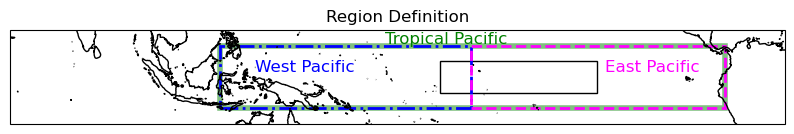

In [55]:
fig,axs = plt.subplots(1,1, figsize=(10,11), subplot_kw={"projection":ccrs.PlateCarree(central_longitude=210)})
axs.coastlines()     
axs.set_extent([53,300,-15,15], crs=ccrs.PlateCarree())

axs.add_patch(patches.Rectangle(xy=[lon_e34, lat_s34], width=(lon_w34-lon_e34), height=(lat_n34-lat_s34),
                            facecolor='none', edgecolor='k',linestyle='-',
                            linewidth=1, transform=ccrs.PlateCarree()))

# Full Pacific
axs.add_patch(patches.Rectangle(xy=[120, -10], width=(281-120), height=20,
                            facecolor='none', edgecolor='green',linestyle='-',alpha=0.5,
                            linewidth=4, transform=ccrs.PlateCarree()))
plt.gcf().text(0.5, 0.5255, 'Tropical Pacific', fontsize=12, color='green')

# # SCS
# axs.add_patch(patches.Rectangle(xy=[100, -10], width=(150-120), height=20,
#                             facecolor='none', edgecolor='orangered',linestyle='-',
#                             linewidth=1, transform=ccrs.PlateCarree()))

# West Pacific
axs.add_patch(patches.Rectangle(xy=[120, -10], width=(200-120), height=20,
                            facecolor='none', edgecolor='blue',linestyle='-.',
                            linewidth=2, transform=ccrs.PlateCarree()))
plt.gcf().text(0.37, 0.5, 'West Pacific', fontsize=12, color='blue')

# East Pacific
axs.add_patch(patches.Rectangle(xy=[200, -10], width=(281-200), height=20,
                            facecolor='none', edgecolor='magenta',linestyle='--',
                            linewidth=2, transform=ccrs.PlateCarree()))

axs.set_title('Region Definition')
plt.gcf().text(0.72, 0.5, 'East Pacific', fontsize=12, color='magenta')



In [89]:
## Create some means over each domain 

tropPacific_all_DS  = allCases.sel(lat=slice(-10,10), lon=slice(120,281))
tropPacific_west_DS = allCases.sel(lat=slice(-10,10), lon=slice(120,200))
tropPacific_east_DS = allCases.sel(lat=slice(-10,10), lon=slice(200,281))

coswgt   = np.cos(np.deg2rad(tropPacific_all_DS.lat))

tropPacific_all_DS_mean   = tropPacific_all_DS.weighted(coswgt).mean(('lon','lat'))
tropPacific_west_DS_mean  = tropPacific_west_DS.weighted(coswgt).mean(('lon','lat'))
tropPacific_east_DS_mean  = tropPacific_east_DS.weighted(coswgt).mean(('lon','lat'))


## Seasonal averages? 
# Get seasonal means 
month_length = tropPacific_all_DS_mean.time.dt.days_in_month
weights = ( month_length.groupby("time.season") / month_length.groupby("time.season").sum() )
weights_all = ( month_length/ month_length.sum() )

# seasonal_tropPacific_all  = tropPacific_all_DS_mean.groupby('time.season').mean(dim='time')
# seasonal_tropPacific_west = tropPacific_west_DS_mean.groupby('time.season').mean(dim='time')
# seasonal_tropPacific_east = tropPacific_east_DS_mean.groupby('time.season').mean(dim='time')
seasonal_tropPacific_all  = (tropPacific_all_DS_mean*weights).groupby('time.season').sum(dim='time')
seasonal_tropPacific_west = (tropPacific_west_DS_mean*weights).groupby('time.season').sum(dim='time')
seasonal_tropPacific_east = (tropPacific_east_DS_mean*weights).groupby('time.season').sum(dim='time')


annual_tropPacific_all  = (tropPacific_all_DS_mean*weights_all).sum(dim='time')


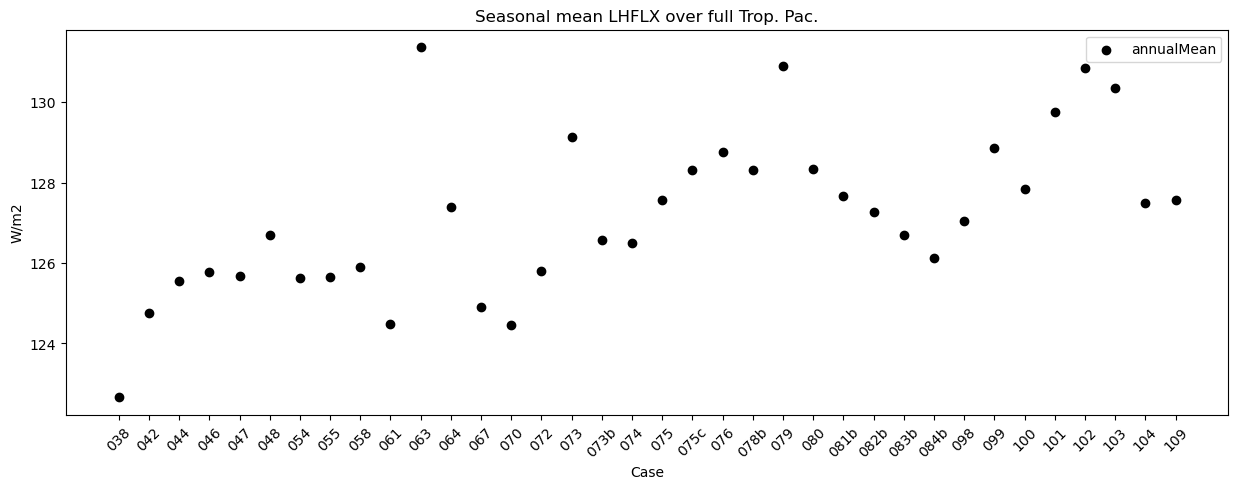

In [91]:
varSel = 'LHFLX'

fig,axs=plt.subplots(1,1,figsize=(15,5))

axs.scatter(allCases.case.values, annual_tropPacific_all[varSel].values, color='k', label='annualMean')

# axs.scatter(allCases.case.values, seasonal_tropPacific_all[varSel].sel(season='JJA').values, color='r', label='JJA')
# axs.scatter(allCases.case.values, seasonal_tropPacific_all[varSel].sel(season='SON').values, color='gold', label='SON')
# axs.scatter(allCases.case.values, seasonal_tropPacific_all[varSel].sel(season='DJF').values, color='dodgerblue', alpha=0.4, label='DJF')
axs.legend()
axs.set_title('Seasonal mean '+varSel+' over full Trop. Pac.')
axs.set_ylabel(allCases[varSel].units)
axs.set_xlabel('Case')

plt.setp( axs.xaxis.get_majorticklabels(), rotation=45 )
plt.show()


## Read CESM2 and CESM1 PI CTRL 

In [3]:
cesm2_dir = '/glade/campaign/collections/cdg/data/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Amon/ts/gn/files/d20190320/'
cesm1_dir = '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/TS/'

listFiles_cesm1 = np.sort(glob.glob(cesm1_dir+'b.e11.B1850C5CN.f09_g16.005.cam.h0.TS.*nc'))
listFiles_cesm2 = np.sort(glob.glob(cesm2_dir+'ts_Amon_CESM2_piControl_r1i1p1f1_gn*.nc'))

DS_all_cesm1 = xr.open_mfdataset(listFiles_cesm1, preprocess=preprocess, concat_dim='time', combine='nested', 
                                 decode_times=False, data_vars='minimal')

DS_all_cesm2 = xr.open_mfdataset(listFiles_cesm2, preprocess=preprocess, concat_dim='time', combine='nested', 
                                 decode_times=False, data_vars='minimal')



/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'ts' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [4]:
%%time 

nYears_cesm1 = len(DS_all_cesm1.time.values)/12
nYears_cesm2 = len(DS_all_cesm2.time.values)/12
print('CESM1 has %i years.\nCESM2 has %i years.' % (nYears_cesm1,nYears_cesm2) )

n_spacing    = int(25)
nYearsPer    = int(50)
# nSamples  = int(np.floor(np.nanmin([((nYears_cesm1 - nYearsPer) // n_spacing + 1), ((nYears_cesm2 - nYearsPer) // n_spacing + 1)])) )
nSamples  = int(np.floor(np.nanmin([((nYears_cesm1 - nYearsPer) // n_spacing + 1), ((nYears_cesm2 - nYearsPer) // n_spacing + 1)])) )
print('Creating %i samples to compute ENSO over, starting every %i years and each with a window of %i years.' % (nSamples, n_spacing, nYearsPer))


#nStartInd = np.arange(0, nSamples*12, n_spacing*12)

# Create an empty array to store the reshaped data
events_cesm1 = np.zeros([nSamples, nYearsPer*12, len(DS_all_cesm1.lat.values), len(DS_all_cesm1.lon.values)])
events_cesm2 = np.zeros([nSamples, nYearsPer*12, len(DS_all_cesm2.lat.values), len(DS_all_cesm2.lon.values)])

# Create a new DataArray with the 'Event' axis
event_coords = np.arange(nSamples)
time_coords = np.arange(nYearsPer*12)

# DS_events_cesm1 = xr.DataArray(events_cesm1, coords=[event_coords, time_coords, DS_all_cesm1.lat.values, DS_all_cesm1.lon.values], 
#                                dims=["event", "time", "lat","lon"])

# DS_events_cesm2 = xr.DataArray(events_cesm2, coords=[event_coords, time_coords, DS_all_cesm2.lat.values, DS_all_cesm2.lon.values], 
                               # dims=["event", "time", "lat","lon"])

## Loop over the events and fill the new array
for iENSO in range(nSamples):
    start_year = iENSO * (n_spacing*12)
    events_cesm1[iENSO, :, :,:] = DS_all_cesm1.TS.isel(time=slice(start_year, (start_year + nYearsPer*12)))
    events_cesm2[iENSO, :, :,:] = DS_all_cesm2.ts.isel(time=slice(start_year, (start_year + nYearsPer*12)))

    # print('Starting with time index %i' % (start_year))




CESM1 has 1801 years.
CESM2 has 1200 years.
Creating 47 samples to compute ENSO over, starting every 25 years and each with a window of 50 years.
CPU times: user 1min 14s, sys: 3.87 s, total: 1min 18s
Wall time: 1min 42s


In [5]:
# Create a new DataArray with the 'Event' axis
event_coords = np.arange(nSamples)
time_coords  = DS_all_cesm1.time.values[17400:18000]

DS_cesm1_events = xr.DataArray(events_cesm1, coords=[event_coords, time_coords, DS_all_cesm1.lat.values, DS_all_cesm1.lon.values], 
                               dims=["event", "time", "lat","lon"])


DS_cesm2_events = xr.DataArray(events_cesm2, coords=[event_coords, time_coords, DS_all_cesm2.lat.values, DS_all_cesm2.lon.values], 
                               dims=["event", "time", "lat","lon"])


## Read in dev cases 

In [5]:
dask.config.set({"array.slicing.split_large_chunks": True})

In [6]:
%%time 

archDir     = '/glade/derecho/scratch/hannay/archive/'

caseNames = [
       # 'b.e23_alpha16g.BLT1850.ne30_t232.079',
       # 'b.e23_alpha16g.BLT1850.ne30_t232.080',
       # 'b.e23_alpha16g.BLT1850.ne30_t232.081b',
       # 'b.e23_alpha16g.BLT1850.ne30_t232.082b',
       # 'b.e23_alpha16g.BLT1850.ne30_t232.083b',
       # 'b.e23_alpha16g.BLT1850.ne30_t232.084b',
       'b.e23_alpha17f.BLT1850.ne30_t232.098',
       # 'b.e23_alpha17f.BLT1850.ne30_t232.099',
       # 'b.e23_alpha17f.BLT1850.ne30_t232.100',
       # 'b.e23_alpha17f.BLT1850.ne30_t232.101',
       # 'b.e23_alpha17f.BLT1850.ne30_t232.102', 
       # 'b.e30_beta02.BLT1850.ne30_t232.103',
       'b.e30_beta02.BLT1850.ne30_t232.104',
       'b.e30_beta02.BLT1850.ne30_t232.109',
]

for iCase in range(len(caseNames)):
    print('*** Starting on case %s ***' % (caseNames[iCase]))

    ## Get list of files 
    listFiles_h0 = np.sort(glob.glob(archDir+caseNames[iCase]+'/atm/hist/*cam.h0*.00??-*'))
    
    ## Now read in those files
    ## Add case ID (short name) to the DS
    x = re.search("BLT1850.ne30_t232.", listFiles_h0[0])
    # caseName = listFiles_h0[0][x.span()[-1]:4+x.span()[-1]]
    caseName = listFiles_h0[0][x.span()[-1]:3+x.span()[-1]]
    print(caseName)

    ## Select only certain years: 
    nYears = 32
    if len(listFiles_h0)<(12*nYears): 
        iEnd = -1 
    else: 
        iEnd = 12*nYears ## Use max of nYears years of data

    listFiles_h0 = listFiles_h0[24:iEnd] #Skip first two years of data 
    
    case_h0 = xr.open_mfdataset(listFiles_h0,  preprocess=preprocess_h0, concat_dim='time', 
                                combine='nested', decode_times=True, 
                                data_vars='minimal', parallel=True)
    print('h0 files loaded')
    
    ## Add case ID (short name) to the DS
    case_h0      = case_h0.squeeze().assign_coords({"case":  caseName})
    
    ## Return all the cases in a single dataset  
    if iCase==0:
        h0_all = case_h0
    else: 
        h0_all = xr.concat([h0_all, case_h0], "case") 


*** Starting on case b.e23_alpha17f.BLT1850.ne30_t232.098 ***
098
h0 files loaded
*** Starting on case b.e30_beta02.BLT1850.ne30_t232.104 ***
104
h0 files loaded
*** Starting on case b.e30_beta02.BLT1850.ne30_t232.109 ***
109
h0 files loaded
CPU times: user 2min 34s, sys: 8.91 s, total: 2min 42s
Wall time: 5min 24s


In [7]:
## Ocean Mask

## create ocean-only frac with case dimension (not time)
fillOcnFrac_h0= np.full([len(h0_all.case.values), len(h0_all.lat.values), len(h0_all.lon.values)], np.nan)
fillOcnFrac_h0[:,:,:] = h0_all.OCNFRAC.isel(case=0, time=0)
fillOcnFrac_h0[np.where(fillOcnFrac_h0!=1)] = np.nan

## Get means 
fillOcnFrac_h0_mean = fillOcnFrac_h0[0,:,:]

## Also create ocean-only frac with time dimension 
fillOcnFrac_h0_allTimes= np.full([len(h0_all.case.values), len(h0_all.time.values), len(h0_all.lat.values), len(h0_all.lon.values)], np.nan)
fillOcnFrac_h0_allTimes[:,:,:,:] = h0_all.OCNFRAC
fillOcnFrac_h0_allTimes[np.where(fillOcnFrac_h0_allTimes!=1)] = np.nan


In [8]:
## Get seasonal means 

month_length = h0_all.time.dt.days_in_month

# Calculate the weights by grouping by 'time.season'.
weights = (month_length.groupby("time.season") / month_length.groupby("time.season").sum())

# Test that the sum of the weights for each season is 1.0
np.testing.assert_allclose(weights.groupby("time.season").sum().values, np.ones(4))

# Calculate the weighted average
allH0_seasonal = (h0_all * weights).groupby("time.season").sum(dim="time")


**Get observations**

In [12]:
## Read in ERA-5 Monthly means for the same period 
filePath = '/glade/work/mdfowler/obs/ERA5_monthlyAvg_1995to2014_fluxesAndRain.nc'
era5_obs = xr.open_dataset(filePath, decode_times=True)

## Add neutral 10m wind components 
fileNeut = '/glade/work/mdfowler/obs/ERA5_monthlyAvg_1995to2014_neutral10mWinds.nc'
era5_neut = xr.open_dataset(fileNeut, decode_times=True)
era5_obs = xr.merge([era5_obs, era5_neut])

era5_obs = era5_obs.reindex(latitude=era5_obs.latitude[::-1])
era5_obs = era5_obs.rename_dims(dims_dict={'latitude':'lat', 'longitude':'lon'})
era5_obs = era5_obs.rename(name_dict={'latitude':'lat', 'longitude':'lon'})

# Now regrid the data
# Get model grid 
camGrid = h0_all['LHFLX'].isel(time=0,case=0).load().squeeze()

# lhflx_era5 = era5_obs['slhf'].where(era5_obs['slhf'].values>-999)
lhflx_era5 = -era5_obs['slhf']/86400  # Divide fluxes by 86400 to get from J/m2 to W/m2; Add negative sign to match CAM convention 
regridERA5_lhflx = regrid_data(lhflx_era5, camGrid, method=1)

## NOW: use neutral winds for 10m u and v 
era5_u10_temp = era5_obs['u10n']
era5_v10_temp = era5_obs['v10n']
u10_era5 = np.sqrt(era5_u10_temp**2 + era5_v10_temp**2)
regridERA5_u10 = regrid_data(u10_era5, camGrid, method=1)

era5_prect_temp  = era5_obs['tp']
era5_prect_temp  =  era5_prect_temp * 1000.0  # Convert from m of water per day to mm/day
regridERA5_prect = regrid_data(era5_prect_temp, camGrid, method=1)

## Combine back into one xarray dataset
regridERA5 = regridERA5_lhflx.to_dataset()
regridERA5['U10'] = (('time','lat','lon'), regridERA5_u10.values)
regridERA5['tp'] = (('time','lat','lon'), regridERA5_prect.values)
# regridERA5 = xr.merge([regridERA5_lhflx, regridERA5_u10, regridERA5_prect])

## Get seasonal means of ERA5 data too 
month_length = regridERA5.time.dt.days_in_month

# Calculate the weights by grouping by 'time.season'.
weights = (month_length.groupby("time.season") / month_length.groupby("time.season").sum())

# Calculate the weighted average
regridERA5_seasonal = (regridERA5 * weights).groupby("time.season").sum(dim="time")


/glade/derecho/scratch/mdfowler/tmp/ipykernel_61753/2691776591.py:12: UserWarning: rename 'latitude' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  era5_obs = era5_obs.rename(name_dict={'latitude':'lat', 'longitude':'lon'})
/glade/derecho/scratch/mdfowler/tmp/ipykernel_61753/2691776591.py:12: UserWarning: rename 'longitude' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  era5_obs = era5_obs.rename(name_dict={'latitude':'lat', 'longitude':'lon'})


## Make plots

In [9]:
longrid, latgrid = np.meshgrid(h0_all['lon'], h0_all['lat'])


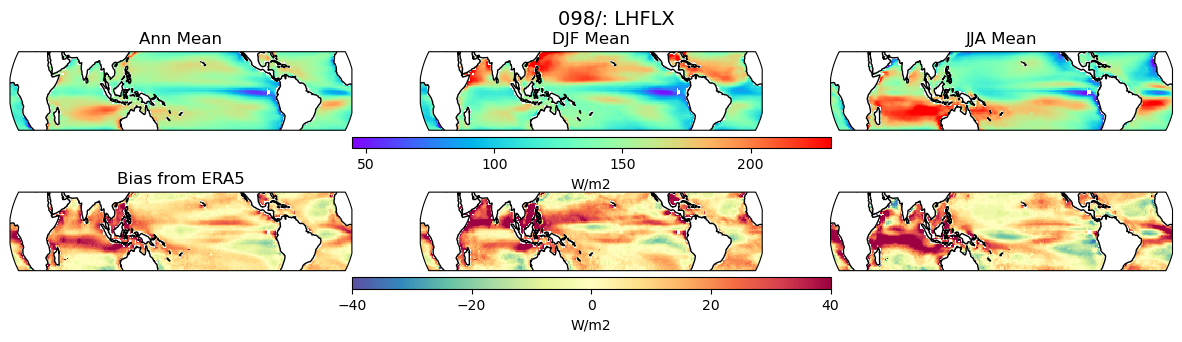

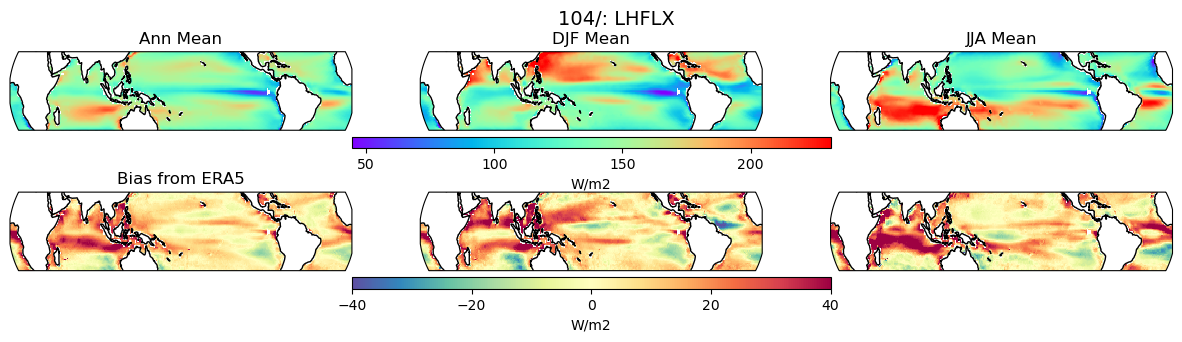

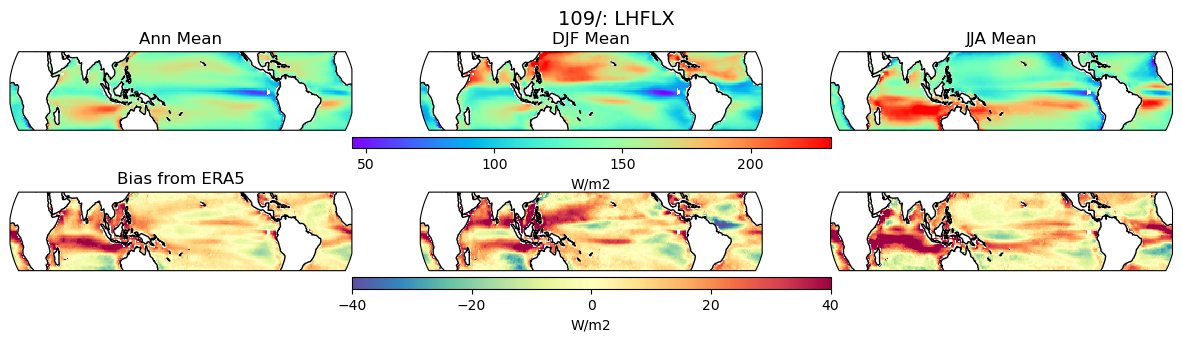

In [41]:
varSel  = 'LHFLX' 
varSelObs = 'slhf'
varMult = 1 
unitStr = 'W/m2'

## Figure out reasonable bounds for plot range 
pMin = np.nanpercentile(h0_all[varSel]*fillOcnFrac_h0_allTimes, 10)
pMax = np.nanpercentile(h0_all[varSel]*fillOcnFrac_h0_allTimes, 98)
var_norm = mpl.colors.Normalize(vmin=pMin, vmax=pMax)

biasMax = 40
bias_norm = mpl.colors.Normalize(vmin=-biasMax, vmax=biasMax)

for iCase in range(len(h0_all.case.values)): 
# for iCase in range(2): 
    fig,ax = plt.subplots(nrows=2, ncols=3, figsize=(15,3), subplot_kw={"projection":ccrs.EckertIV(central_longitude=180)})
    ax = ax.ravel()

    annMean = weighted_temporal_mean(h0_all.isel(case=iCase), varSel) * varMult
    annMeanERA5 = weighted_temporal_mean(regridERA5, varSelObs) 

    img1 = ax[0].pcolormesh(longrid, latgrid, fillOcnFrac_h0_mean*annMean.values, transform=ccrs.PlateCarree(), norm=var_norm, cmap='rainbow')     
    img2 = ax[1].pcolormesh(longrid, latgrid, fillOcnFrac_h0_mean*allH0_seasonal[varSel].isel(case=iCase).sel(season='DJF').values, transform=ccrs.PlateCarree(), norm=var_norm, cmap='rainbow')     
    img3 = ax[2].pcolormesh(longrid, latgrid, fillOcnFrac_h0_mean*allH0_seasonal[varSel].isel(case=iCase).sel(season='JJA').values, transform=ccrs.PlateCarree(), norm=var_norm, cmap='rainbow')  
    # Add colorbar
    cax = ax[1].inset_axes([-0.2, -0.23, 1.4, 0.15])  # THE NEW AXES, x, y, width, height,
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=var_norm, cmap="rainbow"),cax=cax,orientation="horizontal")
    cbar.ax.set_xlabel(unitStr)
    cbar.ax.locator_params(nbins=5)

    ax[0].set_title('Ann Mean')
    ax[1].set_title('DJF Mean')
    ax[2].set_title('JJA Mean')
    plt.gcf().text(0.49, 0.95, str(allH0_seasonal.case.isel(case=iCase).values)+': '+varSel, fontsize=14, color='k')


    ## Also plot biases from ERA5
    img1 = ax[3].pcolormesh(longrid, latgrid, fillOcnFrac_h0_mean*(annMean.values - annMeanERA5.values), 
                            transform=ccrs.PlateCarree(), norm=bias_norm, cmap='Spectral_r')     
    img2 = ax[4].pcolormesh(longrid, latgrid, fillOcnFrac_h0_mean*(allH0_seasonal[varSel].isel(case=iCase).sel(season='DJF').values- regridERA5_seasonal[varSelObs].sel(season='DJF').values), 
                            transform=ccrs.PlateCarree(), norm=bias_norm, cmap='Spectral_r')     
    img3 = ax[5].pcolormesh(longrid, latgrid, fillOcnFrac_h0_mean*(allH0_seasonal[varSel].isel(case=iCase).sel(season='JJA').values- regridERA5_seasonal[varSelObs].sel(season='JJA').values), 
                            transform=ccrs.PlateCarree(), norm=bias_norm, cmap='Spectral_r')  
    # Add colorbar
    cax = ax[4].inset_axes([-0.2, -0.23, 1.4, 0.15])  # THE NEW AXES, x, y, width, height,
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=bias_norm, cmap="Spectral_r"),cax=cax,orientation="horizontal")
    cbar.ax.set_xlabel(unitStr)
    cbar.ax.locator_params(nbins=5)

    ax[3].set_title('Bias from ERA5')
    

    [a.coastlines() for a in ax]
    [a.set_extent([0,358,-30,30],crs=ccrs.PlateCarree()) for a in ax]

    fig.subplots_adjust(hspace=0.55)
    
    plt.show()
    

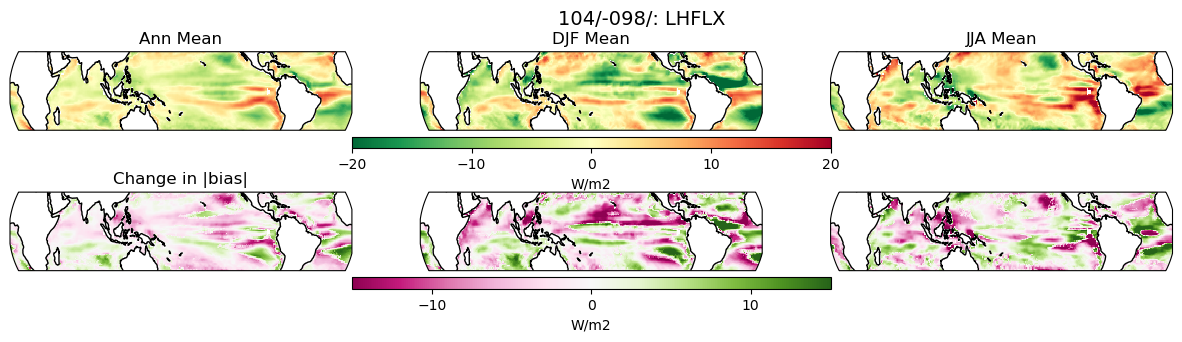

In [29]:
ctrlCase = '098/'
testCase = '104/'

varSel  = 'LHFLX' 
varSelObs = 'slhf'
varMult = 1 
unitStr = 'W/m2'

## Figure out reasonable bounds for plot range 
diffMax = 50
diff_norm = mpl.colors.Normalize(vmin=-diffMax, vmax=diffMax)

biasMax = 10
bias_norm = mpl.colors.Normalize(vmin=-biasMax, vmax=biasMax)


fig,ax = plt.subplots(nrows=2, ncols=3, figsize=(15,3), subplot_kw={"projection":ccrs.EckertIV(central_longitude=180)})
ax = ax.ravel()

annMean_ctrl = weighted_temporal_mean(h0_all.sel(case=ctrlCase), varSel) * varMult
annMean_test = weighted_temporal_mean(h0_all.sel(case=testCase), varSel) * varMult
annMeanERA5 = weighted_temporal_mean(regridERA5, varSelObs) 

## Plot the difference 
img1 = ax[0].pcolormesh(longrid, latgrid, fillOcnFrac_h0_mean*(annMean_test.values-annMean_ctrl.values), 
                        transform=ccrs.PlateCarree(), norm=diff_norm, cmap='RdYlGn_r')     
img2 = ax[1].pcolormesh(longrid, latgrid, fillOcnFrac_h0_mean*(allH0_seasonal[varSel].sel(case=testCase, season='DJF').values - allH0_seasonal[varSel].sel(case=ctrlCase, season='DJF').values), 
                        transform=ccrs.PlateCarree(), norm=diff_norm, cmap='RdYlGn_r')     
img3 = ax[2].pcolormesh(longrid, latgrid, fillOcnFrac_h0_mean*(allH0_seasonal[varSel].sel(case=testCase, season='JJA').values - allH0_seasonal[varSel].sel(case=ctrlCase, season='JJA').values),  
                        transform=ccrs.PlateCarree(), norm=diff_norm, cmap='RdYlGn_r')  
# Add colorbar
cax = ax[1].inset_axes([-0.2, -0.23, 1.4, 0.15])  # THE NEW AXES, x, y, width, height,
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=diff_norm, cmap="RdYlGn_r"),cax=cax,orientation="horizontal")
cbar.ax.set_xlabel(unitStr)
cbar.ax.locator_params(nbins=5)

ax[0].set_title('Ann Mean')
ax[1].set_title('DJF Mean')
ax[2].set_title('JJA Mean')
plt.gcf().text(0.49, 0.95, testCase+'-'+ctrlCase+': '+varSel, fontsize=14, color='k')



## Also plot change in absolute biases from ERA5
ctrlBias_ann = annMean_ctrl.values - annMeanERA5.values
testBias_ann = annMean_test.values - annMeanERA5.values
img1 = ax[3].pcolormesh(longrid, latgrid, fillOcnFrac_h0_mean*(np.abs(testBias_ann)-np.abs(ctrlBias_ann)), 
                        transform=ccrs.PlateCarree(), norm=bias_norm, cmap='PiYG')  

ctrlBias_djf = allH0_seasonal[varSel].sel(case=ctrlCase, season='DJF').values- regridERA5_seasonal[varSelObs].sel(season='DJF').values
testBias_djf = allH0_seasonal[varSel].sel(case=testCase, season='DJF').values- regridERA5_seasonal[varSelObs].sel(season='DJF').values
img2 = ax[4].pcolormesh(longrid, latgrid, fillOcnFrac_h0_mean*(np.abs(testBias_djf)-np.abs(ctrlBias_djf)), 
                        transform=ccrs.PlateCarree(), norm=bias_norm, cmap='PiYG') 

ctrlBias_jja = allH0_seasonal[varSel].sel(case=ctrlCase, season='JJA').values- regridERA5_seasonal[varSelObs].sel(season='JJA').values
testBias_jja = allH0_seasonal[varSel].sel(case=testCase, season='JJA').values- regridERA5_seasonal[varSelObs].sel(season='JJA').values
img3 = ax[5].pcolormesh(longrid, latgrid, fillOcnFrac_h0_mean*(np.abs(testBias_jja)-np.abs(ctrlBias_jja)), 
                        transform=ccrs.PlateCarree(), norm=bias_norm, cmap='PiYG')  
# Add colorbar
cax = ax[4].inset_axes([-0.2, -0.23, 1.4, 0.15])  # THE NEW AXES, x, y, width, height,
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=bias_norm, cmap="PiYG"),cax=cax,orientation="horizontal")
cbar.ax.set_xlabel(unitStr)
cbar.ax.locator_params(nbins=5)

ax[3].set_title('Change in |bias|')


[a.coastlines() for a in ax]
[a.set_extent([0,358,-30,30],crs=ccrs.PlateCarree()) for a in ax]

fig.subplots_adjust(hspace=0.55)

plt.show()


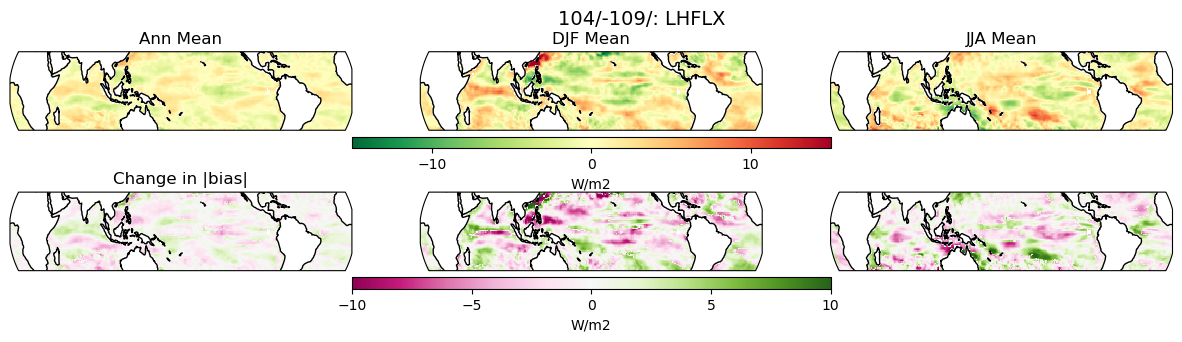

In [31]:
ctrlCase = '109/'
testCase = '104/'

varSel  = 'LHFLX' 
varSelObs = 'slhf'
varMult = 1 
unitStr = 'W/m2'

## Figure out reasonable bounds for plot range 
diffMax = 15
diff_norm = mpl.colors.Normalize(vmin=-diffMax, vmax=diffMax)

biasMax = 10
bias_norm = mpl.colors.Normalize(vmin=-biasMax, vmax=biasMax)


fig,ax = plt.subplots(nrows=2, ncols=3, figsize=(15,3), subplot_kw={"projection":ccrs.EckertIV(central_longitude=180)})
ax = ax.ravel()

annMean_ctrl = weighted_temporal_mean(h0_all.sel(case=ctrlCase), varSel) * varMult
annMean_test = weighted_temporal_mean(h0_all.sel(case=testCase), varSel) * varMult
annMeanERA5 = weighted_temporal_mean(regridERA5, varSelObs) 

## Plot the difference 
img1 = ax[0].pcolormesh(longrid, latgrid, fillOcnFrac_h0_mean*(annMean_test.values-annMean_ctrl.values), 
                        transform=ccrs.PlateCarree(), norm=diff_norm, cmap='RdYlGn_r')     
img2 = ax[1].pcolormesh(longrid, latgrid, fillOcnFrac_h0_mean*(allH0_seasonal[varSel].sel(case=testCase, season='DJF').values - allH0_seasonal[varSel].sel(case=ctrlCase, season='DJF').values), 
                        transform=ccrs.PlateCarree(), norm=diff_norm, cmap='RdYlGn_r')     
img3 = ax[2].pcolormesh(longrid, latgrid, fillOcnFrac_h0_mean*(allH0_seasonal[varSel].sel(case=testCase, season='JJA').values - allH0_seasonal[varSel].sel(case=ctrlCase, season='JJA').values),  
                        transform=ccrs.PlateCarree(), norm=diff_norm, cmap='RdYlGn_r')  
# Add colorbar
cax = ax[1].inset_axes([-0.2, -0.23, 1.4, 0.15])  # THE NEW AXES, x, y, width, height,
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=diff_norm, cmap="RdYlGn_r"),cax=cax,orientation="horizontal")
cbar.ax.set_xlabel(unitStr)
cbar.ax.locator_params(nbins=5)

ax[0].set_title('Ann Mean')
ax[1].set_title('DJF Mean')
ax[2].set_title('JJA Mean')
plt.gcf().text(0.49, 0.95, testCase+'-'+ctrlCase+': '+varSel, fontsize=14, color='k')



## Also plot change in absolute biases from ERA5
ctrlBias_ann = annMean_ctrl.values - annMeanERA5.values
testBias_ann = annMean_test.values - annMeanERA5.values
img1 = ax[3].pcolormesh(longrid, latgrid, fillOcnFrac_h0_mean*(np.abs(testBias_ann)-np.abs(ctrlBias_ann)), 
                        transform=ccrs.PlateCarree(), norm=bias_norm, cmap='PiYG')  

ctrlBias_djf = allH0_seasonal[varSel].sel(case=ctrlCase, season='DJF').values- regridERA5_seasonal[varSelObs].sel(season='DJF').values
testBias_djf = allH0_seasonal[varSel].sel(case=testCase, season='DJF').values- regridERA5_seasonal[varSelObs].sel(season='DJF').values
img2 = ax[4].pcolormesh(longrid, latgrid, fillOcnFrac_h0_mean*(np.abs(testBias_djf)-np.abs(ctrlBias_djf)), 
                        transform=ccrs.PlateCarree(), norm=bias_norm, cmap='PiYG') 

ctrlBias_jja = allH0_seasonal[varSel].sel(case=ctrlCase, season='JJA').values- regridERA5_seasonal[varSelObs].sel(season='JJA').values
testBias_jja = allH0_seasonal[varSel].sel(case=testCase, season='JJA').values- regridERA5_seasonal[varSelObs].sel(season='JJA').values
img3 = ax[5].pcolormesh(longrid, latgrid, fillOcnFrac_h0_mean*(np.abs(testBias_jja)-np.abs(ctrlBias_jja)), 
                        transform=ccrs.PlateCarree(), norm=bias_norm, cmap='PiYG')  
# Add colorbar
cax = ax[4].inset_axes([-0.2, -0.23, 1.4, 0.15])  # THE NEW AXES, x, y, width, height,
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=bias_norm, cmap="PiYG"),cax=cax,orientation="horizontal")
cbar.ax.set_xlabel(unitStr)
cbar.ax.locator_params(nbins=5)

ax[3].set_title('Change in |bias|')

[a.coastlines() for a in ax]
[a.set_extent([0,358,-30,30],crs=ccrs.PlateCarree()) for a in ax]

fig.subplots_adjust(hspace=0.55)

plt.show()


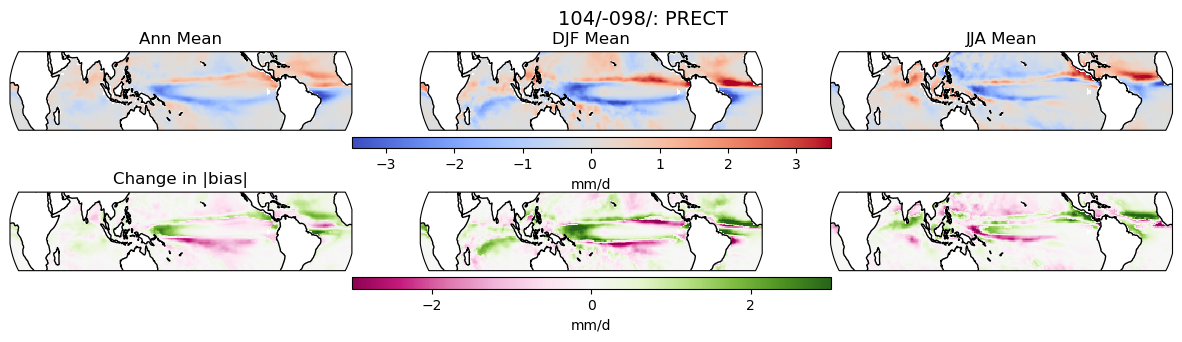

In [40]:
ctrlCase = '098/'
testCase = '104/'

varSel  = 'PRECT' 
varSelObs = 'tp'
varMult = 8.64e7
unitStr = 'mm/d'

## Figure out reasonable bounds for plot range 
diffMax   = 3.5
diff_norm = mpl.colors.Normalize(vmin=-diffMax, vmax=diffMax)

biasMax   = 3
bias_norm = mpl.colors.Normalize(vmin=-biasMax, vmax=biasMax)


fig,ax = plt.subplots(nrows=2, ncols=3, figsize=(15,3), subplot_kw={"projection":ccrs.EckertIV(central_longitude=180)})
ax = ax.ravel()

annMean_ctrl = weighted_temporal_mean(h0_all.sel(case=ctrlCase), varSel) * varMult
annMean_test = weighted_temporal_mean(h0_all.sel(case=testCase), varSel) * varMult
annMeanERA5 = weighted_temporal_mean(regridERA5, varSelObs) 

## Plot the difference 
img1 = ax[0].pcolormesh(longrid, latgrid, fillOcnFrac_h0_mean*(annMean_test.values-annMean_ctrl.values), 
                        transform=ccrs.PlateCarree(), norm=diff_norm, cmap='coolwarm')     
img2 = ax[1].pcolormesh(longrid, latgrid, fillOcnFrac_h0_mean*((allH0_seasonal[varSel].sel(case=testCase, season='DJF').values) - allH0_seasonal[varSel].sel(case=ctrlCase, season='DJF').values)*varMult, 
                        transform=ccrs.PlateCarree(), norm=diff_norm, cmap='coolwarm')     
img3 = ax[2].pcolormesh(longrid, latgrid, fillOcnFrac_h0_mean*((allH0_seasonal[varSel].sel(case=testCase, season='JJA').values) - allH0_seasonal[varSel].sel(case=ctrlCase, season='JJA').values)*varMult,  
                        transform=ccrs.PlateCarree(), norm=diff_norm, cmap='coolwarm')  
# Add colorbar
cax = ax[1].inset_axes([-0.2, -0.23, 1.4, 0.15])  # THE NEW AXES, x, y, width, height,
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=diff_norm, cmap="coolwarm"),cax=cax,orientation="horizontal")
cbar.ax.set_xlabel(unitStr)
cbar.ax.locator_params(nbins=7)

ax[0].set_title('Ann Mean')
ax[1].set_title('DJF Mean')
ax[2].set_title('JJA Mean')
plt.gcf().text(0.49, 0.95, testCase+'-'+ctrlCase+': '+varSel, fontsize=14, color='k')



## Also plot change in absolute biases from ERA5
ctrlBias_ann = annMean_ctrl.values - annMeanERA5.values
testBias_ann = annMean_test.values - annMeanERA5.values
img1 = ax[3].pcolormesh(longrid, latgrid, fillOcnFrac_h0_mean*(np.abs(testBias_ann)-np.abs(ctrlBias_ann)), 
                        transform=ccrs.PlateCarree(), norm=bias_norm, cmap='PiYG')  

ctrlBias_djf = (varMult*allH0_seasonal[varSel].sel(case=ctrlCase, season='DJF').values) - regridERA5_seasonal[varSelObs].sel(season='DJF').values
testBias_djf = (varMult*allH0_seasonal[varSel].sel(case=testCase, season='DJF').values) - regridERA5_seasonal[varSelObs].sel(season='DJF').values
img2 = ax[4].pcolormesh(longrid, latgrid, fillOcnFrac_h0_mean*(np.abs(testBias_djf)-np.abs(ctrlBias_djf)), 
                        transform=ccrs.PlateCarree(), norm=bias_norm, cmap='PiYG') 

ctrlBias_jja = (varMult*allH0_seasonal[varSel].sel(case=ctrlCase, season='JJA').values) - regridERA5_seasonal[varSelObs].sel(season='JJA').values
testBias_jja = (varMult*allH0_seasonal[varSel].sel(case=testCase, season='JJA').values) - regridERA5_seasonal[varSelObs].sel(season='JJA').values
img3 = ax[5].pcolormesh(longrid, latgrid, fillOcnFrac_h0_mean*(np.abs(testBias_jja)-np.abs(ctrlBias_jja)), 
                        transform=ccrs.PlateCarree(), norm=bias_norm, cmap='PiYG')  
# Add colorbar
cax = ax[4].inset_axes([-0.2, -0.23, 1.4, 0.15])  # THE NEW AXES, x, y, width, height,
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=bias_norm, cmap="PiYG"),cax=cax,orientation="horizontal")
cbar.ax.set_xlabel(unitStr)
cbar.ax.locator_params(nbins=5)

ax[3].set_title('Change in |bias|')

[a.coastlines() for a in ax]
[a.set_extent([0,358,-30,30],crs=ccrs.PlateCarree()) for a in ax]

fig.subplots_adjust(hspace=0.55)

plt.show()


In [11]:
h0_all.case.values

array(['098', '104', '109'], dtype='<U3')

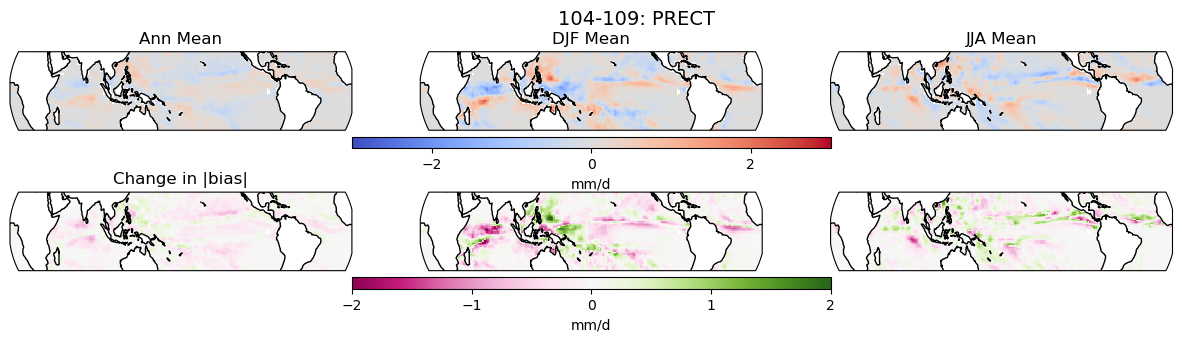

In [14]:
ctrlCase = '109'
testCase = '104'

varSel  = 'PRECT' 
varSelObs = 'tp'
varMult = 8.64e7
unitStr = 'mm/d'

## Figure out reasonable bounds for plot range 
diffMax   = 3
diff_norm = mpl.colors.Normalize(vmin=-diffMax, vmax=diffMax)

biasMax   = 2
bias_norm = mpl.colors.Normalize(vmin=-biasMax, vmax=biasMax)


fig,ax = plt.subplots(nrows=2, ncols=3, figsize=(15,3), subplot_kw={"projection":ccrs.EckertIV(central_longitude=180)})
ax = ax.ravel()

annMean_ctrl = weighted_temporal_mean(h0_all.sel(case=ctrlCase), varSel) * varMult
annMean_test = weighted_temporal_mean(h0_all.sel(case=testCase), varSel) * varMult
annMeanERA5 = weighted_temporal_mean(regridERA5, varSelObs) 

## Plot the difference 
img1 = ax[0].pcolormesh(longrid, latgrid, fillOcnFrac_h0_mean*(annMean_test.values-annMean_ctrl.values), 
                        transform=ccrs.PlateCarree(), norm=diff_norm, cmap='coolwarm')     
img2 = ax[1].pcolormesh(longrid, latgrid, fillOcnFrac_h0_mean*((allH0_seasonal[varSel].sel(case=testCase, season='DJF').values) - allH0_seasonal[varSel].sel(case=ctrlCase, season='DJF').values)*varMult, 
                        transform=ccrs.PlateCarree(), norm=diff_norm, cmap='coolwarm')     
img3 = ax[2].pcolormesh(longrid, latgrid, fillOcnFrac_h0_mean*((allH0_seasonal[varSel].sel(case=testCase, season='JJA').values) - allH0_seasonal[varSel].sel(case=ctrlCase, season='JJA').values)*varMult,  
                        transform=ccrs.PlateCarree(), norm=diff_norm, cmap='coolwarm')  
# Add colorbar
cax = ax[1].inset_axes([-0.2, -0.23, 1.4, 0.15])  # THE NEW AXES, x, y, width, height,
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=diff_norm, cmap="coolwarm"),cax=cax,orientation="horizontal")
cbar.ax.set_xlabel(unitStr)
cbar.ax.locator_params(nbins=5)

ax[0].set_title('Ann Mean')
ax[1].set_title('DJF Mean')
ax[2].set_title('JJA Mean')
plt.gcf().text(0.49, 0.95, testCase+'-'+ctrlCase+': '+varSel, fontsize=14, color='k')



## Also plot change in absolute biases from ERA5
ctrlBias_ann = annMean_ctrl.values - annMeanERA5.values
testBias_ann = annMean_test.values - annMeanERA5.values
img1 = ax[3].pcolormesh(longrid, latgrid, fillOcnFrac_h0_mean*(np.abs(testBias_ann)-np.abs(ctrlBias_ann)), 
                        transform=ccrs.PlateCarree(), norm=bias_norm, cmap='PiYG')  

ctrlBias_djf = (varMult*allH0_seasonal[varSel].sel(case=ctrlCase, season='DJF').values) - regridERA5_seasonal[varSelObs].sel(season='DJF').values
testBias_djf = (varMult*allH0_seasonal[varSel].sel(case=testCase, season='DJF').values) - regridERA5_seasonal[varSelObs].sel(season='DJF').values
img2 = ax[4].pcolormesh(longrid, latgrid, fillOcnFrac_h0_mean*(np.abs(testBias_djf)-np.abs(ctrlBias_djf)), 
                        transform=ccrs.PlateCarree(), norm=bias_norm, cmap='PiYG') 

ctrlBias_jja = (varMult*allH0_seasonal[varSel].sel(case=ctrlCase, season='JJA').values) - regridERA5_seasonal[varSelObs].sel(season='JJA').values
testBias_jja = (varMult*allH0_seasonal[varSel].sel(case=testCase, season='JJA').values) - regridERA5_seasonal[varSelObs].sel(season='JJA').values
img3 = ax[5].pcolormesh(longrid, latgrid, fillOcnFrac_h0_mean*(np.abs(testBias_jja)-np.abs(ctrlBias_jja)), 
                        transform=ccrs.PlateCarree(), norm=bias_norm, cmap='PiYG')  
# Add colorbar
cax = ax[4].inset_axes([-0.2, -0.23, 1.4, 0.15])  # THE NEW AXES, x, y, width, height,
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=bias_norm, cmap="PiYG"),cax=cax,orientation="horizontal")
cbar.ax.set_xlabel(unitStr)
cbar.ax.locator_params(nbins=5)

ax[3].set_title('Change in |bias|')

[a.coastlines() for a in ax]
[a.set_extent([0,358,-30,30],crs=ccrs.PlateCarree()) for a in ax]

fig.subplots_adjust(hspace=0.55)

plt.show()
